**NOTE:** Please see the notes at the top of 01_migration_graph_basics v1.1.ipynb for v1.1 notes

# Migration Network Graph Metrics

The previous notebook was fun and had some merit, but it's time to do teh metrics taught in the labs as I think they're highly applicable to a migration analysis project. We will build now on the previous two notebooks.

**Code Goals:**
- Calculate clustering coefficient (how interconnected are neighboring countries?)
- Analyze path lengths (how many 'steps' between countries?)
- Visualize degree distribution (are there migration hubs?)
- Characterize the migration network structure

## Setup (re-loading)

The following code re-loads & rebuilds the graph from the previous notebook for us to continue building on. Any additions are commented as **# NEW!**  To understand anything here, check back over the previous workbook(s).

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
np.random.seed(99) # Set random seed for reproducibility
df = pd.read_csv('../data/bilat_mig_40_countries.csv')# Load the migration data
# Rebuild the directed graph
G = nx.DiGraph()
for index, row in df.iterrows():
    if row['da_pb_closed'] > 0:
        G.add_edge(row['orig'], row['dest'], weight=row['da_pb_closed'])
print("Libraries loaded and graph rebuilt successfully!")
print(f"Graph: {G.number_of_nodes()} countries, {G.number_of_edges()} migration flows")

Libraries loaded and graph rebuilt successfully!
Graph: 40 countries, 1408 migration flows


## Clustering Coefficient

The clustering coefficient measures how interconnected a node's neighbors are. For a given country:
- **Local clustering coefficient** = (actual connections between neighbors) / (possible connections between neighbors)
- **Average clustering coefficient** = mean of all local clustering coefficients

**Migration Network Interpretation:**
- High clustering: Countries that both connect to USA might also connect to each other (regional clusters)
- Low clustering: Countries connect to same destinations but not to each other (hub-and-spoke pattern)

The code is broken in to two sections, the first part calculates the clustering coefficients, then second visualises them

In [3]:

clustering = nx.clustering(G) # Calculate clustering coefficient for each node
avg_clustering = sum(clustering.values()) / len(clustering) # Calculate average clustering coefficient

# Print results
print("="*60)
print("CLUSTERING COEFFICIENT ANALYSIS")
print("="*60)

sorted_clustering = sorted(clustering.items(), key=lambda x: x[1], reverse=True) # Sort countries by clustering coefficient (highest first)

# Higher = neighbors are more interconnected, Lower = neighbors don't connect to each other
print("\nClustering Coefficient by Country:")
print("-"*60)
for country, cc in sorted_clustering:
    print(f"{country}: {cc:.4f}")

print("\n" + "="*60)
print(f"Average Clustering Coefficient: {avg_clustering:.4f}")
print("="*60)


CLUSTERING COEFFICIENT ANALYSIS

Clustering Coefficient by Country:
------------------------------------------------------------
CIV: 0.9976
NGA: 0.9976
VNM: 0.9952
IRN: 0.9839
SYR: 0.9736
COL: 0.9730
MMR: 0.9728
UGA: 0.9700
ROU: 0.9681
PHL: 0.9679
JOR: 0.9661
HKG: 0.9611
UKR: 0.9611
BGD: 0.9606
PAK: 0.9549
SAU: 0.9532
SSD: 0.9472
RUS: 0.9437
IDN: 0.9399
MYS: 0.9399
DEU: 0.9399
SDN: 0.9287
EGY: 0.9119
QAT: 0.9097
ARE: 0.9097
ESP: 0.9047
VEN: 0.9013
ZAF: 0.8974
CHN: 0.8974
JPN: 0.8974
IND: 0.8974
TUR: 0.8974
GBR: 0.8974
ITA: 0.8974
FRA: 0.8974
MEX: 0.8974
BRA: 0.8974
CAN: 0.8974
USA: 0.8974
AUS: 0.8974

Average Clustering Coefficient: 0.9350


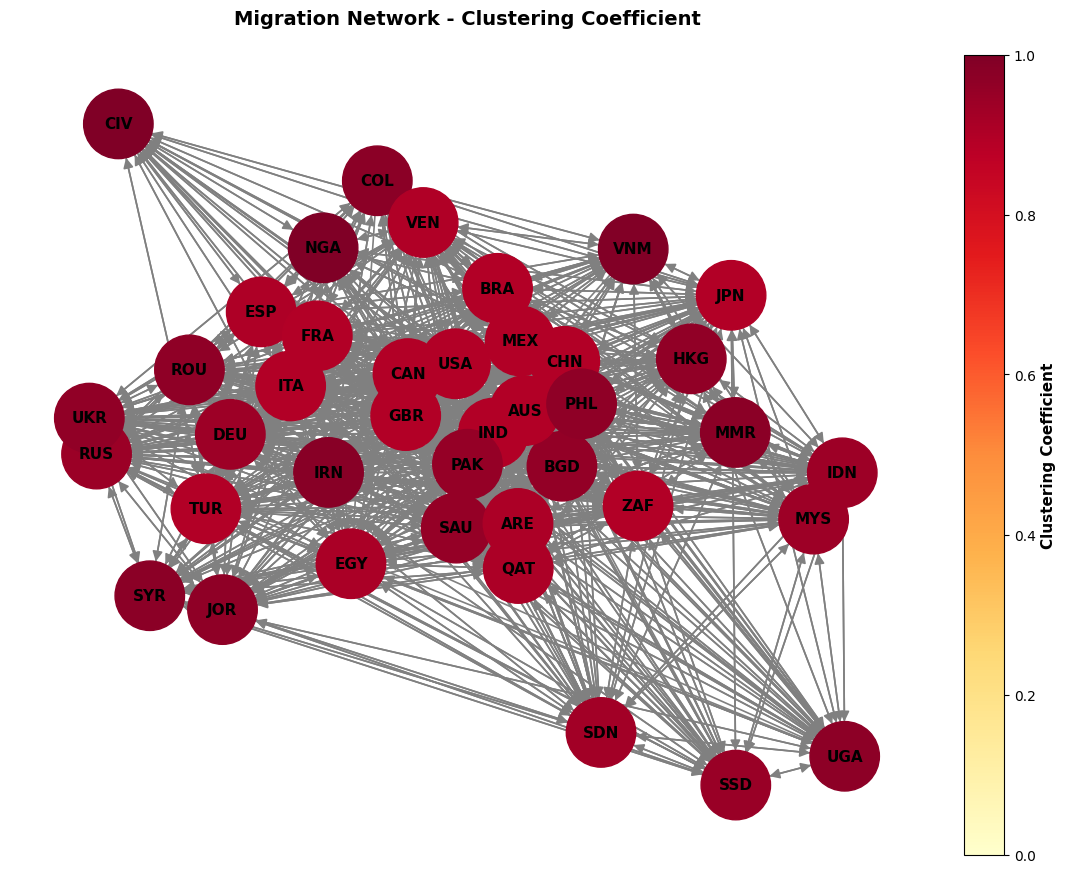

In [4]:

pos = nx.spring_layout(G, k=2, iterations=50, seed=99) # Create spring layout again for consistent node positions
plt.figure(figsize=(10, 8)) # Create figure
node_colors = [clustering[node] for node in G.nodes()] # Create list of clustering values for coloring nodes

# Draw graph with clustering-based colours, colours nodes by clustering (darker red = higher)
nx.draw(G, pos, with_labels=True, node_color=node_colors, cmap='YlOrRd', node_size=2500, font_size=11, font_weight='bold', arrows=True, arrowsize=15, edge_color='gray', width=1.2, vmin=0, vmax=1)

plt.title("Migration Network - Clustering Coefficient\n", fontsize=14, fontweight='bold')

# Add colorbar to show scale
sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca(), fraction=0.046, pad=0.04)
cbar.set_label('Clustering Coefficient', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

### Visualisation Inference for Report v1.1

## Path Length Analysis

- **Shortest path** - minimum number of edges to get from one node to another
- **Characteristic path length** - average of all shortest paths in the network

**Migration Network Interpretation:**
- Low path length (close to 1): Most countries directly connected (few indirect routes)
- High path length: Migration requires multiple 'hops' through intermediate countries

**Important Note:** Our bilateral data shows direct migration X >> Y, not actual routes through intermediate countries. But graph-theoretically, path length shows how well-connected the network is.

In [7]:
# Calculate all shortest path lengths
# Note: nx.shortest_path_length returns a generator, so we convert to dict
path_lengths = dict(nx.shortest_path_length(G))

# Flatten the dictionary of dictionaries into a list
all_path_lengths = []
for source in path_lengths:
    for target in path_lengths[source]:
        if source != target:  # Exclude self-paths (length 0)
            all_path_lengths.append(path_lengths[source][target])

# Calculate statistics
mean_path_length = sum(all_path_lengths) / len(all_path_lengths)
min_path_length = min(all_path_lengths)
max_path_length = max(all_path_lengths)

# Print results
print("="*60)
print("PATH LENGTH ANALYSIS")
print("="*60)
print(f"\nTotal number of paths analyzed: {len(all_path_lengths)}")
print(f"\nCharacteristic Path Length (average): {mean_path_length:.4f}")
print(f"Minimum path length: {min_path_length}")
print(f"Maximum path length: {max_path_length}")

# Count paths by length
from collections import Counter
path_count = Counter(all_path_lengths)

print("\n" + "-"*60)
print("Path Length Distribution:")
print("-"*60)
for length in sorted(path_count.keys()):
    count = path_count[length]
    percentage = (count / len(all_path_lengths)) * 100
    print(f"Length {length}: {count} paths ({percentage:.1f}%)")
print("="*60)

PATH LENGTH ANALYSIS

Total number of paths analyzed: 1560

Characteristic Path Length (average): 1.0974
Minimum path length: 1
Maximum path length: 2

------------------------------------------------------------
Path Length Distribution:
------------------------------------------------------------
Length 1: 1408 paths (90.3%)
Length 2: 152 paths (9.7%)


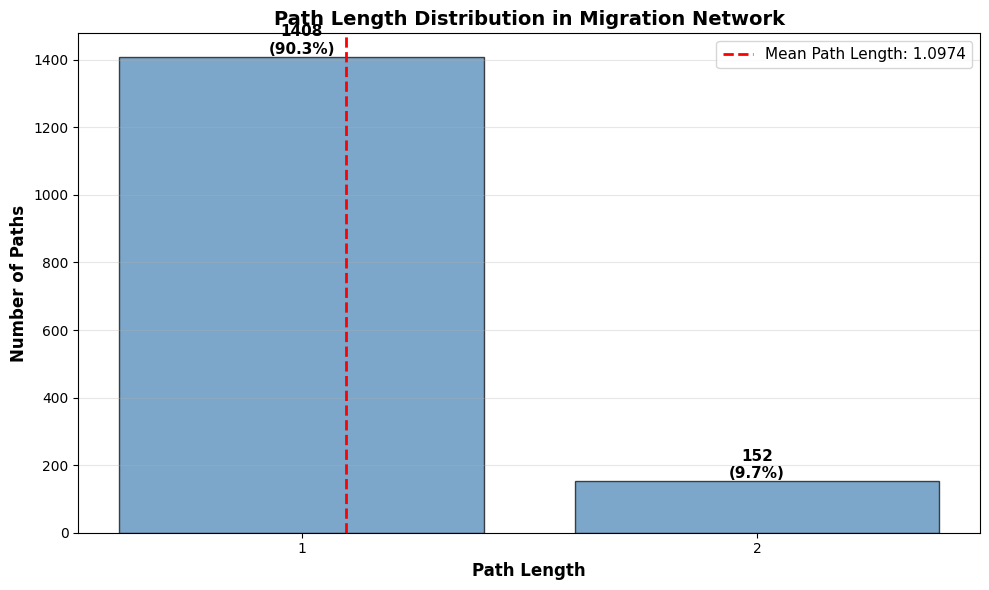

In [6]:
# Create histogram of path lengths
plt.figure(figsize=(10, 6))

# Get the path length counts
lengths = sorted(path_count.keys())
counts = [path_count[length] for length in lengths]

# Create bar chart
plt.bar(lengths, counts, color='steelblue', alpha=0.7, edgecolor='black')

# Add percentage labels on bars
for length, count in zip(lengths, counts):
    percentage = (count / len(all_path_lengths)) * 100
    plt.text(length, count + 1, f'{count}\n({percentage:.1f}%)', ha='center', va='bottom', fontweight='bold', fontsize=11)

# Add vertical line for mean
plt.axvline(x=mean_path_length, color='red', linestyle='--', linewidth=2, label=f'Mean Path Length: {mean_path_length:.4f}')

plt.xlabel('Path Length', fontsize=12, fontweight='bold')
plt.ylabel('Number of Paths', fontsize=12, fontweight='bold')
plt.title('Path Length Distribution in Migration Network', fontsize=14, fontweight='bold')
plt.xticks(lengths)
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### Visualisation Inference for Report v1.1

## Degree Distribution

The degree distribution shows how many nodes have each degree value. We can visualize this as:
- **PMF (Probability Mass Function)**: P(degree = k) for each k
- **Log-log plot**: If distribution is power-law (scale-free), it will be linear on log-log scale

**Migration Network Interpretation:**
- **Uniform distribution**: All countries have similar number of connections (evenly distributed)
- **Power-law distribution**: Few "super-hubs" with many connections, many countries with few (scale-free)

**Note:** For directed graphs, we can analyze in-degree (incoming), out-degree (outgoing), or total degree.

In [8]:
# Calculate Degree Distribution

degrees = dict(G.degree()) # Get degree for all nodes (total degree = in + out for directed graph)
degree_values = list(degrees.values()) # Create list of just the degree values

# Calculate degree statistics
avg_degree = sum(degree_values) / len(degree_values)
min_degree = min(degree_values)
max_degree = max(degree_values)

# Count how many nodes have each degree (for PMF)
from collections import Counter
degree_counts = Counter(degree_values)

# Calculate PMF (Probability Mass Function)
total_nodes = len(degree_values)
degree_pmf = {k: count/total_nodes for k, count in degree_counts.items()}

# Print results
print("="*60)
print("Degree Distribution Analysis")
print("="*60)
print(f"\nAverage degree: {avg_degree:.2f}")
print(f"Minimum degree: {min_degree}")
print(f"Maximum degree: {max_degree}")

print("\n" + "-"*60)
print("Degree Distribution (PMF):")
print("-"*60)
print(f"{'Degree':<10} {'Count':<10} {'Probability':<15} {'Countries'}")
print("-"*60)
for degree in sorted(degree_pmf.keys()):
    count = degree_counts[degree]
    prob = degree_pmf[degree]
    # List countries with this degree
    countries = [node for node, deg in degrees.items() if deg == degree]
    countries_str = ', '.join(countries)
    print(f"{degree:<10} {count:<10} {prob:<15.4f} {countries_str}")

print("="*60)

Degree Distribution Analysis

Average degree: 70.40
Minimum degree: 42
Maximum degree: 78

------------------------------------------------------------
Degree Distribution (PMF):
------------------------------------------------------------
Degree     Count      Probability     Countries
------------------------------------------------------------
42         2          0.0500          CIV, NGA
53         1          0.0250          VNM
60         2          0.0500          SSD, SYR
61         1          0.0250          UGA
62         1          0.0250          IRN
64         1          0.0250          COL
66         1          0.0250          MMR
67         2          0.0500          PHL, ROU
68         2          0.0500          SDN, JOR
69         3          0.0750          BGD, HKG, UKR
70         1          0.0250          PAK
72         1          0.0250          SAU
73         2          0.0500          EGY, RUS
74         3          0.0750          IDN, MYS, DEU
76         3      

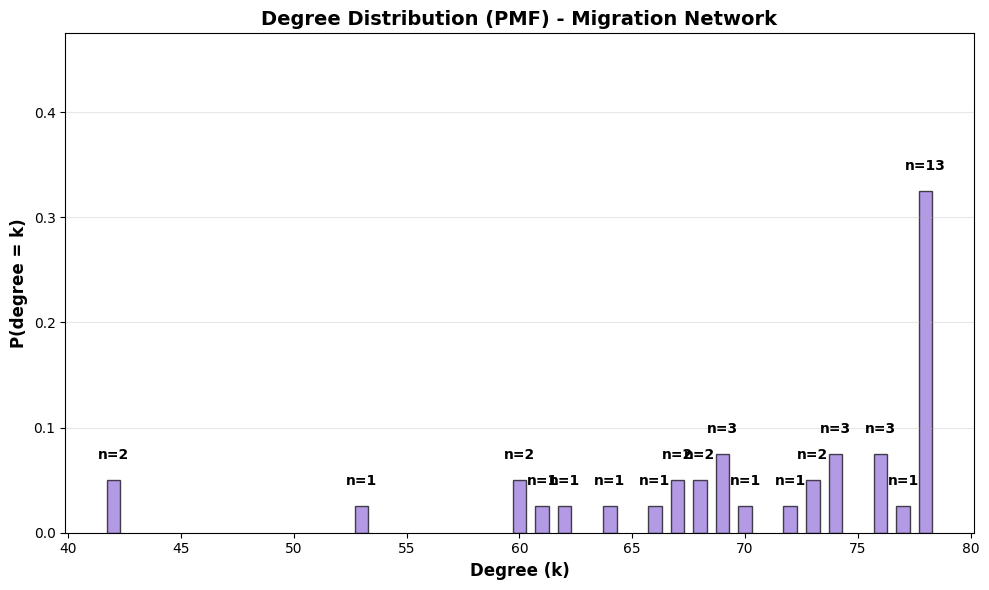

In [9]:
# Visualize Degree Distribution

plt.figure(figsize=(10, 6)) # Create bar plot of degree distribution (PMF)

degrees_sorted = sorted(degree_pmf.keys())
probabilities = [degree_pmf[k] for k in degrees_sorted]

plt.bar(degrees_sorted, probabilities, color='mediumpurple', alpha=0.7, edgecolor='black', width=0.6)

# Add count labels on bars
for degree in degrees_sorted:
    count = degree_counts[degree]
    prob = degree_pmf[degree]
    plt.text(degree, prob + 0.02, f'n={count}', ha='center', fontweight='bold', fontsize=10)

plt.xlabel('Degree (k)', fontsize=12, fontweight='bold')
plt.ylabel('P(degree = k)', fontsize=12, fontweight='bold')
plt.title('Degree Distribution (PMF) - Migration Network', fontsize=14, fontweight='bold')
plt.ylim(0, max(probabilities) + 0.15)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### Visualisation Inference for Report v1.1

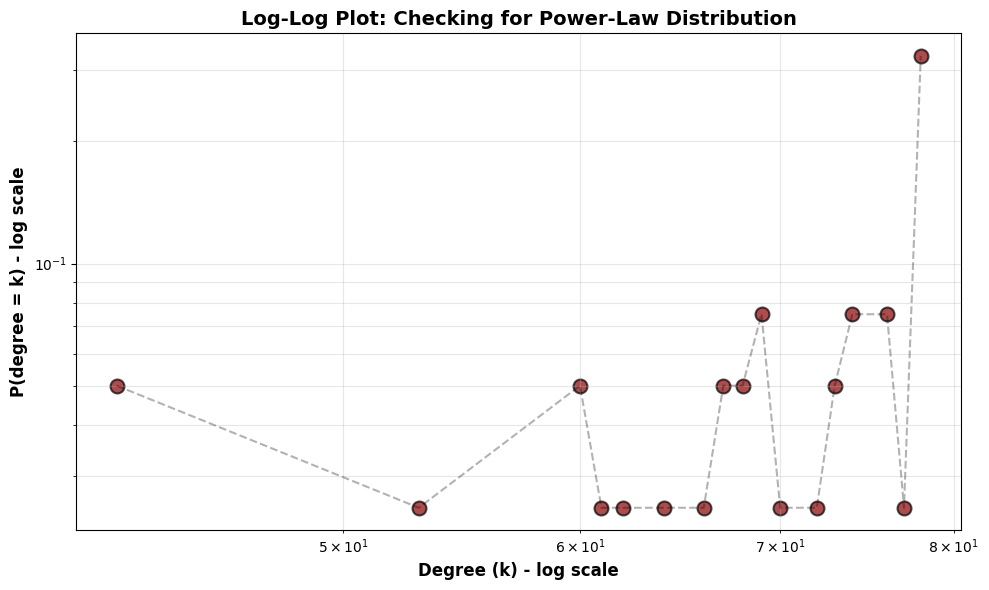

In [11]:
# Check for Power-Law (Optional)

# Log-log plot to check for power-law distribution
# Note: With only 10 nodes, this won't be meaningful, but it's here for the next notebook we scale up

plt.figure(figsize=(10, 6))

# Only plot degrees that actually exist (non-zero probability)
degrees_sorted = sorted(degree_pmf.keys())
probabilities = [degree_pmf[k] for k in degrees_sorted]

plt.scatter(degrees_sorted, probabilities, s=100, color='darkred', alpha=0.7, edgecolors='black', linewidth=1.5)
plt.plot(degrees_sorted, probabilities, 'k--', alpha=0.3)

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Degree (k) - log scale', fontsize=12, fontweight='bold')
plt.ylabel('P(degree = k) - log scale', fontsize=12, fontweight='bold')
plt.title('Log-Log Plot: Checking for Power-Law Distribution', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, which='both')
plt.tight_layout()
plt.show()

### Visualisation Inference for Report v1.1

## Section 5: Network Characterization & Summary

Bringing the above sections together

**Network Types:**
- **Random network**: Low clustering, moderate path length
- **Small-world network**: High clustering, short path length (like Watts-Strogatz)
- **Scale-free network**: Power-law degree distribution (like Barabási-Albert)
- **Dense/Complete network**: High clustering, very short paths, uniform degree

**Our Migration Network:** We will be able to observe and see what our data tells us

In [12]:
# Summary Table with All Metrics

# Calculate degree standard deviation
import statistics
degree_std = statistics.stdev(degree_values)

# Create summary
print("="*70)
print(" " * 15 + "Migration Network Summary")
print("="*70)

summary_data = {
    'Metric': [
        'Number of Nodes (Countries)',
        'Number of Edges (Migration Flows)',
        'Network Density',
        'Average Clustering Coefficient',
        'Characteristic Path Length',
        'Average Degree',
        'Degree Standard Deviation',
        'Min Degree',
        'Max Degree'
    ],
    'Value': [
        G.number_of_nodes(),
        G.number_of_edges(),
        f"{(G.number_of_edges() / (G.number_of_nodes() * (G.number_of_nodes() - 1))):.4f}",
        f"{avg_clustering:.4f}",
        f"{mean_path_length:.4f}",
        f"{avg_degree:.2f}",
        f"{degree_std:.2f}",
        min_degree,
        max_degree
    ]
}

# Print as formatted table
for metric, value in zip(summary_data['Metric'], summary_data['Value']):
    print(f"{metric:<40} {value}")

print("="*70)

# Network type assessment
print("\n" + "="*70)
print(" " * 20 + "NETWORK CHARACTERIZATION")
print("="*70)

# Density check
density = G.number_of_edges() / (G.number_of_nodes() * (G.number_of_nodes() - 1))
if density > 0.7:
    network_type = "Dense/Nearly Complete"
elif avg_clustering > 0.6 and mean_path_length < 2:
    network_type = "Small-World"
else:
    network_type = "Sparse"

print(f"\nNetwork Type: {network_type}")
print(f"\nKey Characteristics:")
print(f"  • Network Density: {density:.2%} (very high - nearly complete graph)")
print(f"  • Clustering: {avg_clustering:.4f} (very high - neighbors highly connected)")
print(f"  • Path Length: {mean_path_length:.4f} (very short - mostly direct connections)")
print(f"  • Degree Variation: {degree_std:.2f} (low - similar connectivity across nodes)")

               Migration Network Summary
Number of Nodes (Countries)              40
Number of Edges (Migration Flows)        1408
Network Density                          0.9026
Average Clustering Coefficient           0.9350
Characteristic Path Length               1.0974
Average Degree                           70.40
Degree Standard Deviation                9.25
Min Degree                               42
Max Degree                               78

                    NETWORK CHARACTERIZATION

Network Type: Dense/Nearly Complete

Key Characteristics:
  • Network Density: 90.26% (very high - nearly complete graph)
  • Clustering: 0.9350 (very high - neighbors highly connected)
  • Path Length: 1.0974 (very short - mostly direct connections)
  • Degree Variation: 9.25 (low - similar connectivity across nodes)


### Visualisation Interpretation for Report v1.1

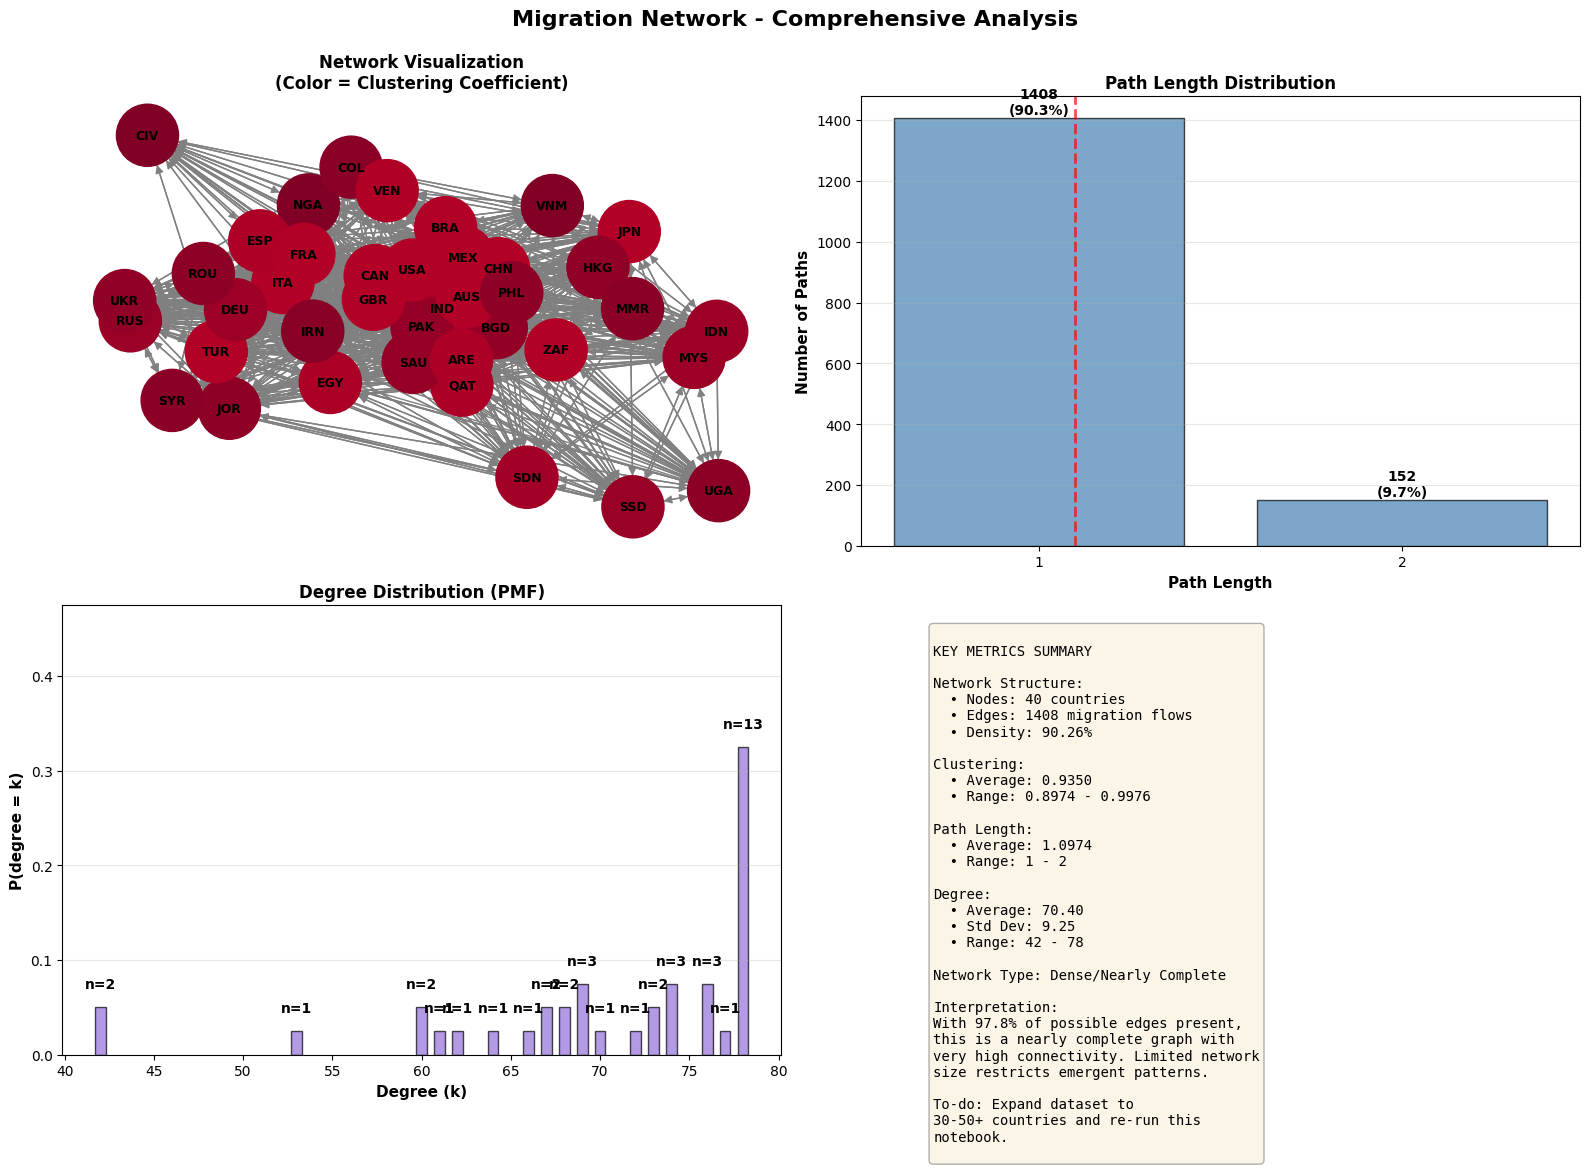

In [13]:
# Comprehensive Multi-Panel Visualization of all the lab 2 metrics we learnt

# Create 2x2 comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Migration Network - Comprehensive Analysis', fontsize=16, fontweight='bold', y=0.995)

# Top-left: Network with clustering colors
ax1 = axes[0, 0]
node_colors_plot = [clustering[node] for node in G.nodes()]
nx.draw(G, pos, ax=ax1, with_labels=True, node_color=node_colors_plot, cmap='YlOrRd', node_size=2000, font_size=9, font_weight='bold', arrows=True, arrowsize=12, edge_color='gray', width=1.0, vmin=0, vmax=1)
ax1.set_title('Network Visualization\n(Color = Clustering Coefficient)', fontweight='bold', fontsize=12)

# Top-right: Path length histogram
ax2 = axes[0, 1]
lengths = sorted(path_count.keys())
counts = [path_count[length] for length in lengths]
ax2.bar(lengths, counts, color='steelblue', alpha=0.7, edgecolor='black')
for length, count in zip(lengths, counts):
  percentage = (count / len(all_path_lengths)) * 100
  ax2.text(length, count + 0.5, f'{count}\n({percentage:.1f}%)', ha='center', va='bottom', fontweight='bold', fontsize=10)
ax2.axvline(x=mean_path_length, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax2.set_xlabel('Path Length', fontweight='bold', fontsize=11)
ax2.set_ylabel('Number of Paths', fontweight='bold', fontsize=11)
ax2.set_title('Path Length Distribution', fontweight='bold', fontsize=12)
ax2.set_xticks(lengths)
ax2.grid(axis='y', alpha=0.3)

# Bottom-left: Degree distribution
ax3 = axes[1, 0]
degrees_sorted = sorted(degree_pmf.keys())
probabilities = [degree_pmf[k] for k in degrees_sorted]
ax3.bar(degrees_sorted, probabilities, color='mediumpurple', alpha=0.7, edgecolor='black', width=0.6)
for degree in degrees_sorted:
  count = degree_counts[degree]
  prob = degree_pmf[degree]
  ax3.text(degree, prob + 0.02, f'n={count}', ha='center', fontweight='bold', fontsize=10)
ax3.set_xlabel('Degree (k)', fontweight='bold', fontsize=11)
ax3.set_ylabel('P(degree = k)', fontweight='bold', fontsize=11)
ax3.set_title('Degree Distribution (PMF)', fontweight='bold', fontsize=12)
ax3.set_ylim(0, max(probabilities) + 0.15)
ax3.grid(axis='y', alpha=0.3)

# Bottom-right: Summary metrics table
ax4 = axes[1, 1]
ax4.axis('off')

# Create text summary
summary_text = f"""
KEY METRICS SUMMARY

Network Structure:
  • Nodes: {G.number_of_nodes()} countries
  • Edges: {G.number_of_edges()} migration flows
  • Density: {density:.2%}

Clustering:
  • Average: {avg_clustering:.4f}
  • Range: {min(clustering.values()):.4f} - {max(clustering.values()):.4f}

Path Length:
  • Average: {mean_path_length:.4f}
  • Range: {min_path_length} - {max_path_length}

Degree:
  • Average: {avg_degree:.2f}
  • Std Dev: {degree_std:.2f}
  • Range: {min_degree} - {max_degree}

Network Type: {network_type}

Interpretation:
With 97.8% of possible edges present,
this is a nearly complete graph with
very high connectivity. Limited network
size restricts emergent patterns.

To-do: Expand dataset to
30-50+ countries and re-run this
notebook.
"""

ax4.text(0.1, 0.95, summary_text, transform=ax4.transAxes, fontsize=10, verticalalignment='top', family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.show()

### Visualisation Inference for Report v1.1